In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from matplotlib import pyplot as plt
import sys

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import bo_methods_lib
from bo_methods_lib.bo_functions_generic import gen_theta_set

from bo_methods_lib.CS2_bo_plotters import plot_obj_abs_min, value_plotter, plot_obj, plot_Theta, plot_Theta_min,path_name, plot_org_train, save_fig, plot_EI_abs_max

from bo_methods_lib.CS2_bo_functions_multi_dim import set_ep

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html

def csv_to_array(csv_path):
    """
    Turn a csv file into a numpy array so that it can be used with bo_plotters
    
    Parameters:
    -----------
        csv_path: str, path of csv you want to turn into an array
    Returns:
    --------
        csv_array: np.ndarray, array on values in the CSV file
    """
    
    csv_pd = pd.read_csv(csv_path, index_col = False)
    csv_pd.drop(columns=csv_pd.columns[0], 
        axis=1, 
        inplace=True)
    csv_array = csv_pd.to_numpy()
    
    return csv_array

In [108]:
df = pd.read_csv("CS1_best_run_sse.csv", header = 0, index_col = None)
# print(df.head)
print(df.columns)


# # sort the dataframe
df.sort_values(by=['Method', "Separation Factor", "Run"], axis=0, inplace=True)

print(df['Method'].unique())
print(df['Separation Factor'].unique())
print(df['Run'].unique())
print(df.head())

Index(['Method', 'Separation Factor', 'Run', 'Iteration', 'SSE', 'Max Eval',
       'Minimum SSE', 'Theta 1', 'Min Theta 1', 'Theta 2', 'Min Theta 2',
       'Time/Iter (Minutes)', 'Total Run Time'],
      dtype='object')
['1A' '1B' '2A' '2B' '2C']
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  Method  Separation Factor  Run  Iteration         SSE  Max Eval  \
0     1A                0.1    1        100    0.031549       100   
1     1A                0.1    2        100    3.109907       100   
2     1A                0.1    3         45    0.000068       100   
3     1A                0.1    4          1  123.414795         2   
4     1A                0.1    5          2   43.893042         2   

   Minimum SSE   Theta 1  Min Theta 1   Theta 2  Min Theta 2  \
0     0.031549  0.984937     0.984937 -1.033389    -1.033389   
1     3.109907  1.551446     1.551446 -1.012198    -1.012198   
2     0.000068  0.994778     0.994778 -1.004316    -1.0

In [115]:
#Loop over each method
names=df['Method'].unique().tolist()

#Initialize dataframes
df_best = pd.DataFrame()
df_median = pd.DataFrame()
df_25 = pd.DataFrame()
df_75 = pd.DataFrame()
df_mean = pd.DataFrame()
df_min = pd.DataFrame()
df_max = pd.DataFrame()

#Loop over names
for name in names:
    #Loop over separation factors
    for SF in df['Separation Factor'].unique():
        #Create new temp df to organize data
        df_meth = df.loc[(df['Method'] == name) & (df["Separation Factor"]==SF)]
        #Find best performing run,       
        df_meth_SF_Best = df_meth.loc[(np.isclose(df_meth["Minimum SSE"],df_meth['Minimum SSE'].min())) ]
        
        #If many runs have the same value, only take the first one
        if len(df_meth_SF_Best) > 1:
            df_meth_SF_Best = df_meth_SF_Best.reset_index(drop=True)
            df_meth_SF_Best = df_meth_SF_Best.loc[df_meth_SF_Best.index == 0]
            
        df_best = pd.concat([df_best, df_meth_SF_Best])
        #OR Find median run and 25 and 75 percentiles
        df_median_mid = df_meth[df_meth['SSE']==df_meth['SSE'].quantile(interpolation='nearest')]
        df_25_mid = df_meth[df_meth['SSE']==df_meth['SSE'].quantile(0.25, interpolation='nearest')]
        df_75_mid = df_meth[df_meth['SSE']==df_meth['SSE'].quantile(0.75, interpolation='nearest')]
        
        #If many runs have the same value, only take the first one
        if len(df_median_mid) > 1:
            df_median_mid = df_median_mid.reset_index(drop=True)
            df_median_mid = df_median_mid.loc[df_median_mid.index == 0]
            df_25_mid = df_25_mid.reset_index(drop=True)
            df_25_mid = df_25_mid.loc[df_25_mid.index == 0]
            df_75_mid = df_75_mid.reset_index(drop=True)
            df_75_mid = df_75_mid.loc[df_75_mid.index == 0]
            
        df_median = pd.concat([df_median, df_median_mid])
        df_25 = pd.concat([df_25, df_25_mid])
        df_75 = pd.concat([df_75, df_75_mid])
        
        #OR Find mean run with best and worst
        #Find true median
        df_true_mean = df_meth['Minimum SSE'].mean()
        #Find point closest to true median
        df_closest_to_mean = df_meth.iloc[(df_meth['Minimum SSE']-df_true_mean).abs().argsort()[:1]]
        #Add mean min and max points to dfs
        df_mean = pd.concat([df_mean, df_closest_to_mean])
        df_min = pd.concat([df_min, df_meth.loc[(np.isclose(df_meth["Minimum SSE"],df_meth['Minimum SSE'].min())) ]])
        df_max = pd.concat([df_max, df_meth.loc[(np.isclose(df_meth["Minimum SSE"],df_meth['Minimum SSE'].max())) ]])

#Add theta_true columns to df_median, df_best, and df_mean
Theta_True = np.array([1,-1])
df_median[["True Theta 1", "True Theta 2"]] = Theta_True
df_best[["True Theta 1", "True Theta 2"]] = Theta_True
df_mean[["True Theta 1", "True Theta 2"]] = Theta_True
print((df_mean.tail()))
 


    Method  Separation Factor  Run  Iteration       SSE  Max Eval  \
682     2C                0.6    8          4  0.375665         4   
694     2C                0.7    5          8  0.008161         9   
715     2C                0.8   11          5  0.042610         6   
726     2C                0.9    7          4  0.025702         5   
747     2C                1.0   13          5  0.002814         6   

     Minimum SSE   Theta 1  Min Theta 1   Theta 2  Min Theta 2  \
682     0.375665  0.924179     0.924179 -0.905295    -0.905295   
694     0.008161  0.982391     0.982391 -0.989223    -0.989223   
715     0.042610  0.944464     0.944464 -0.980321    -0.980321   
726     0.025702  0.953988     0.953988 -0.986499    -0.986499   
747     0.002814  0.994307     0.994307 -0.994294    -0.994294   

     Time/Iter (Minutes)  Total Run Time  True Theta 1  True Theta 2  
682                0.615           2.460             1            -1  
694                0.615           5.535      

mean


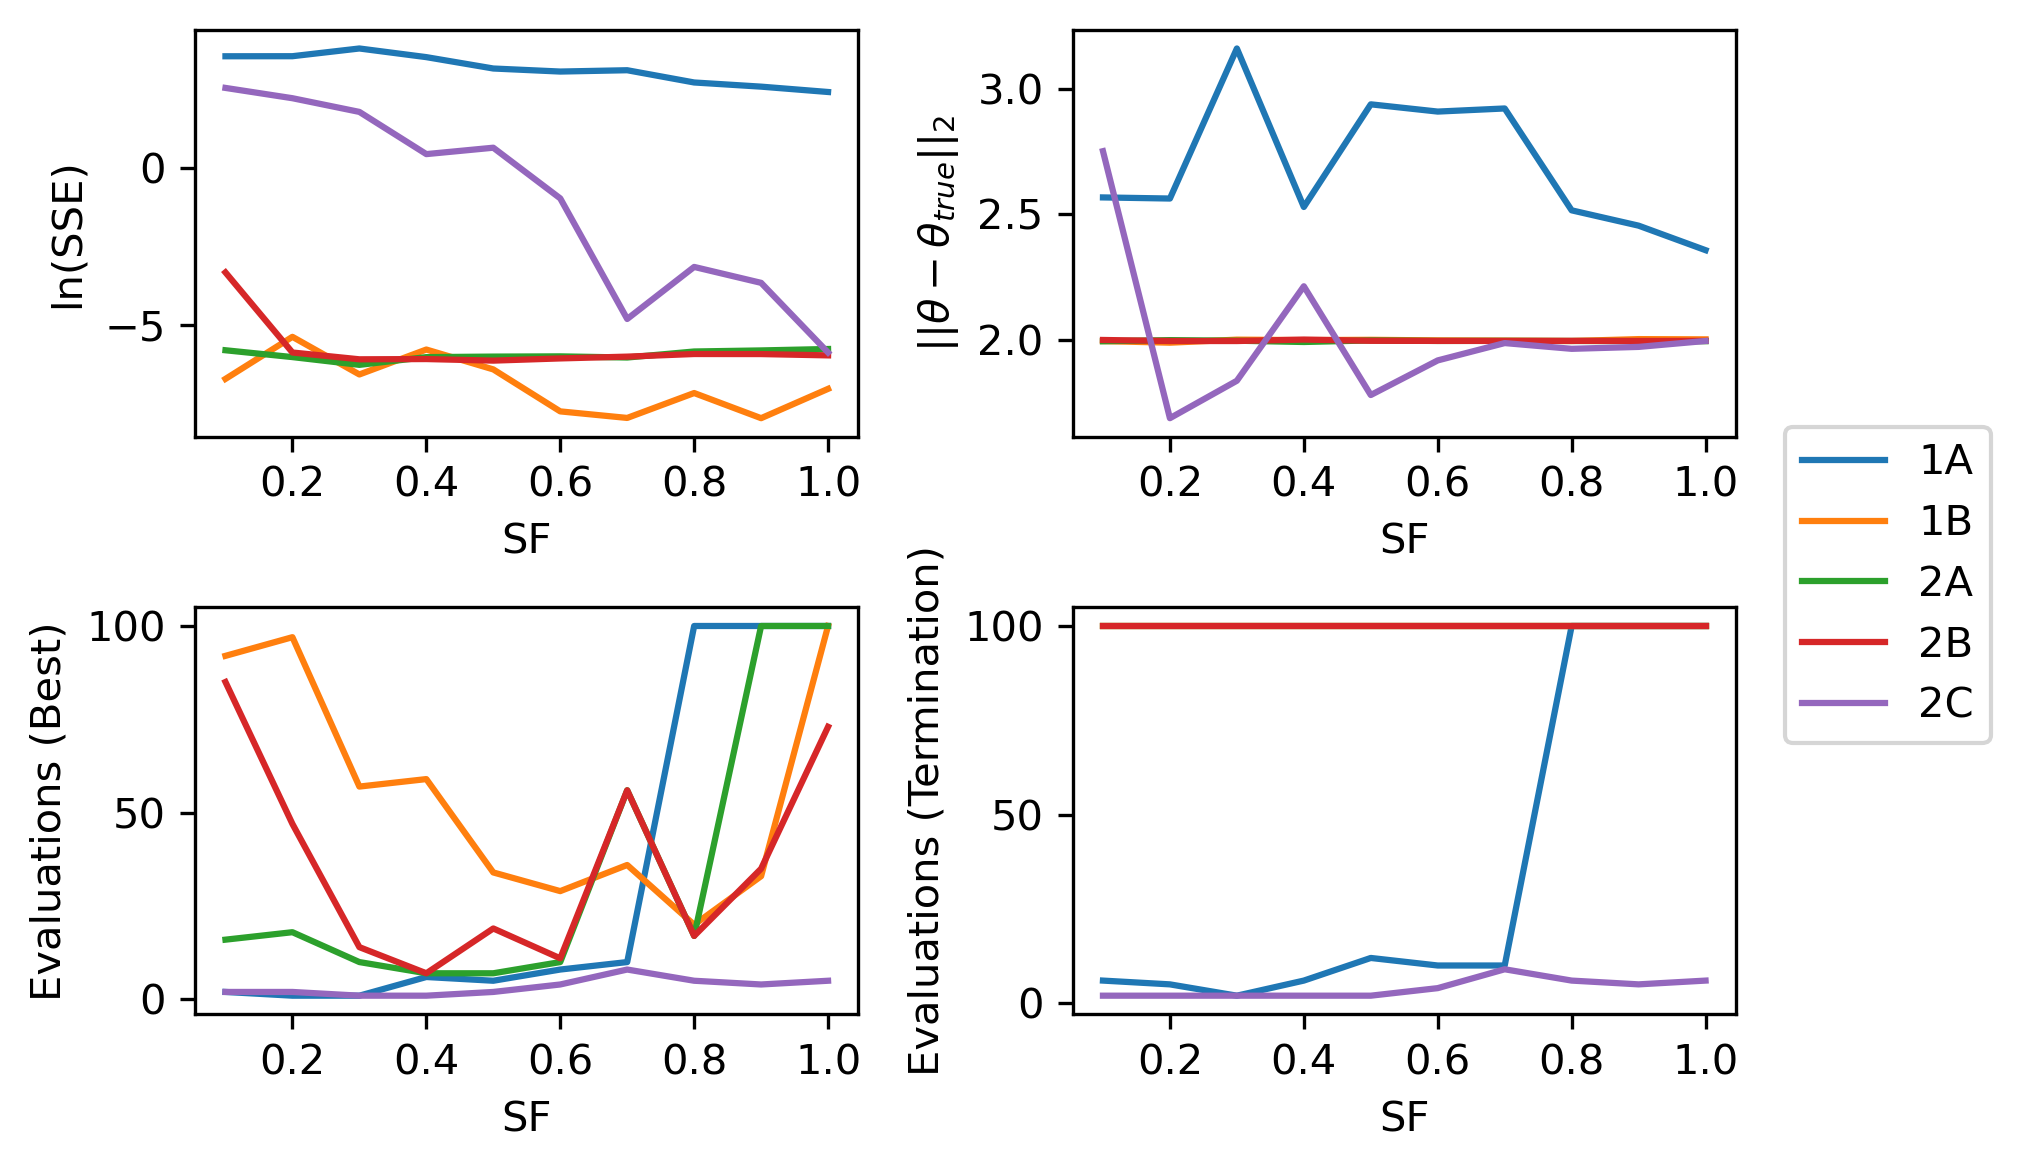

median


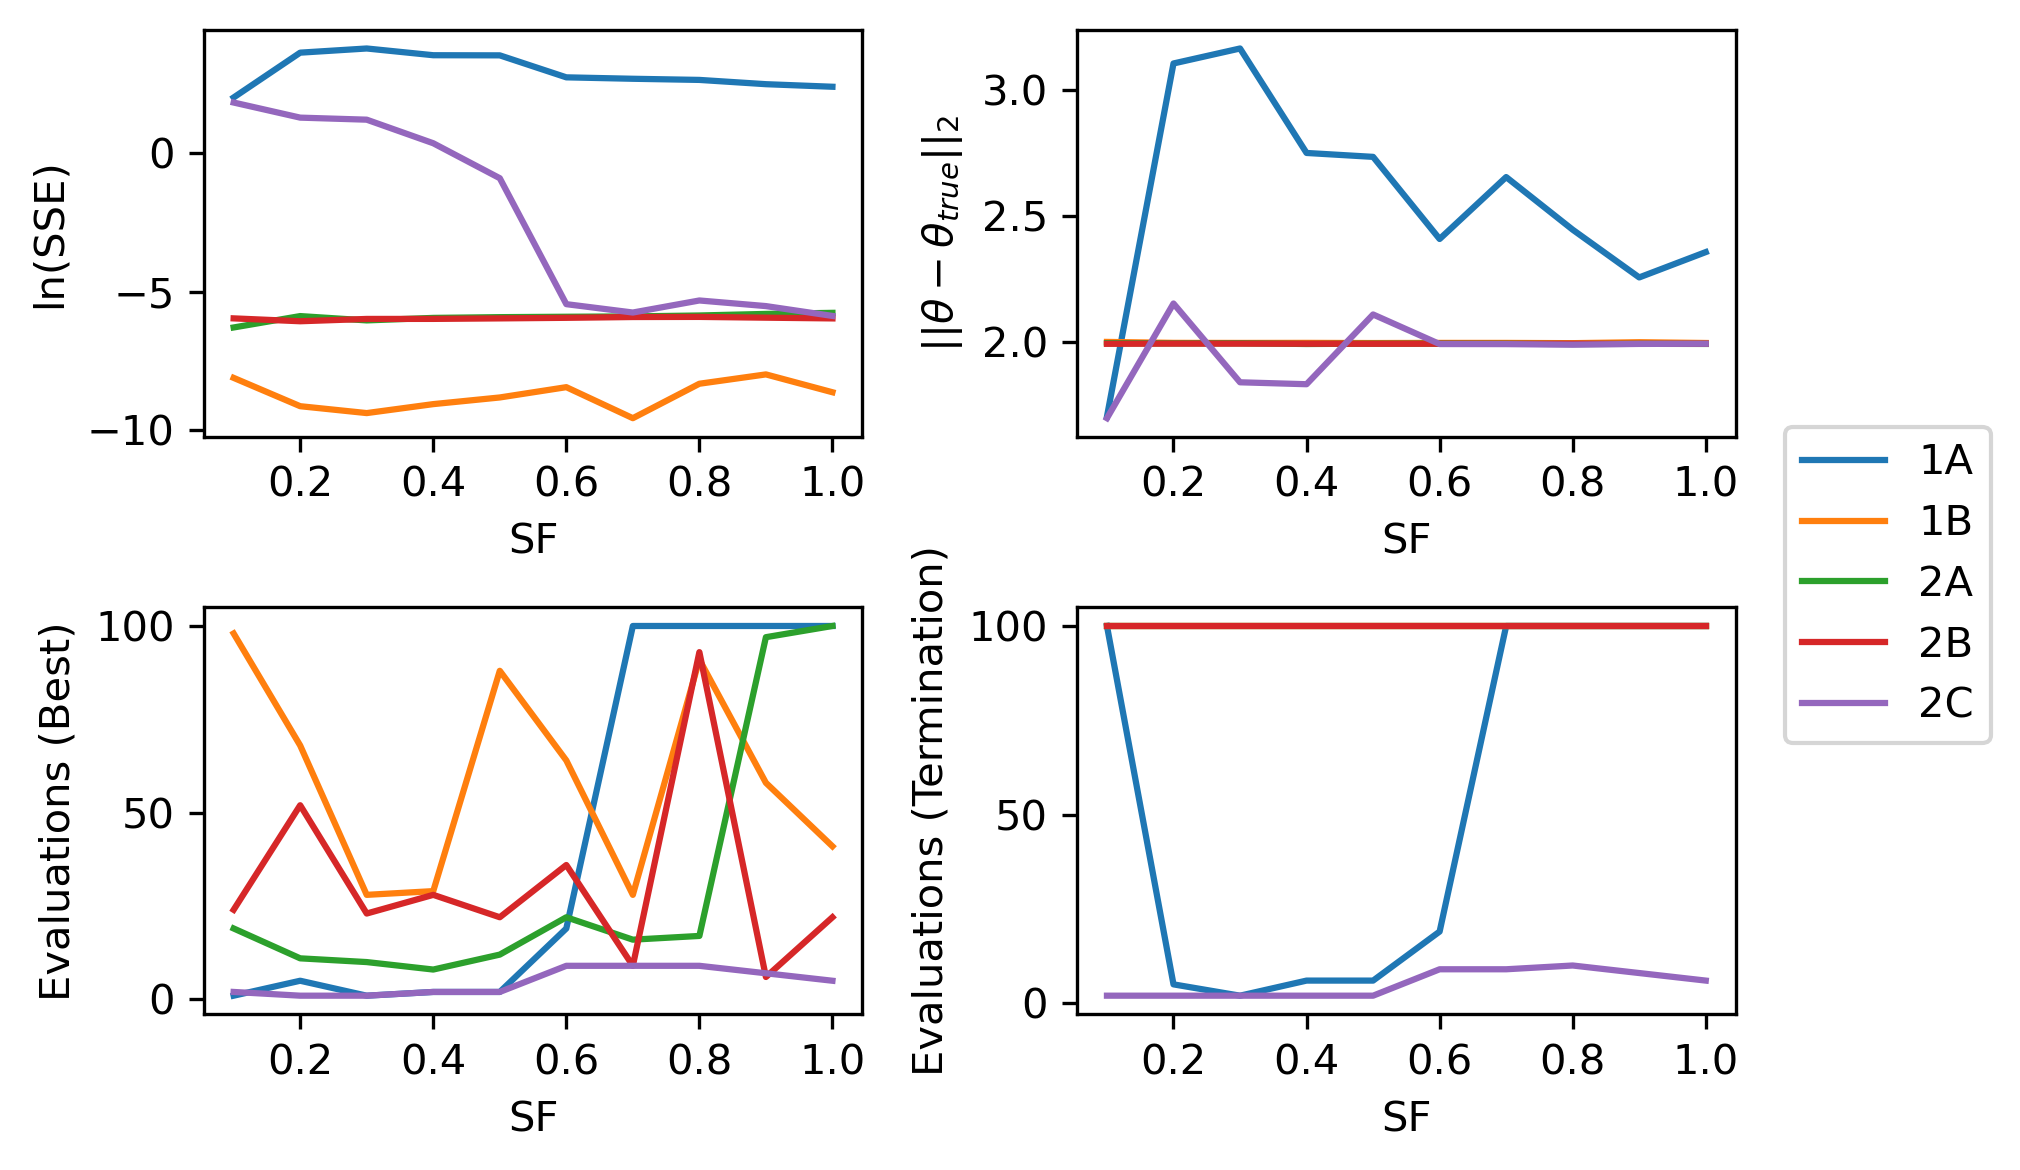

best


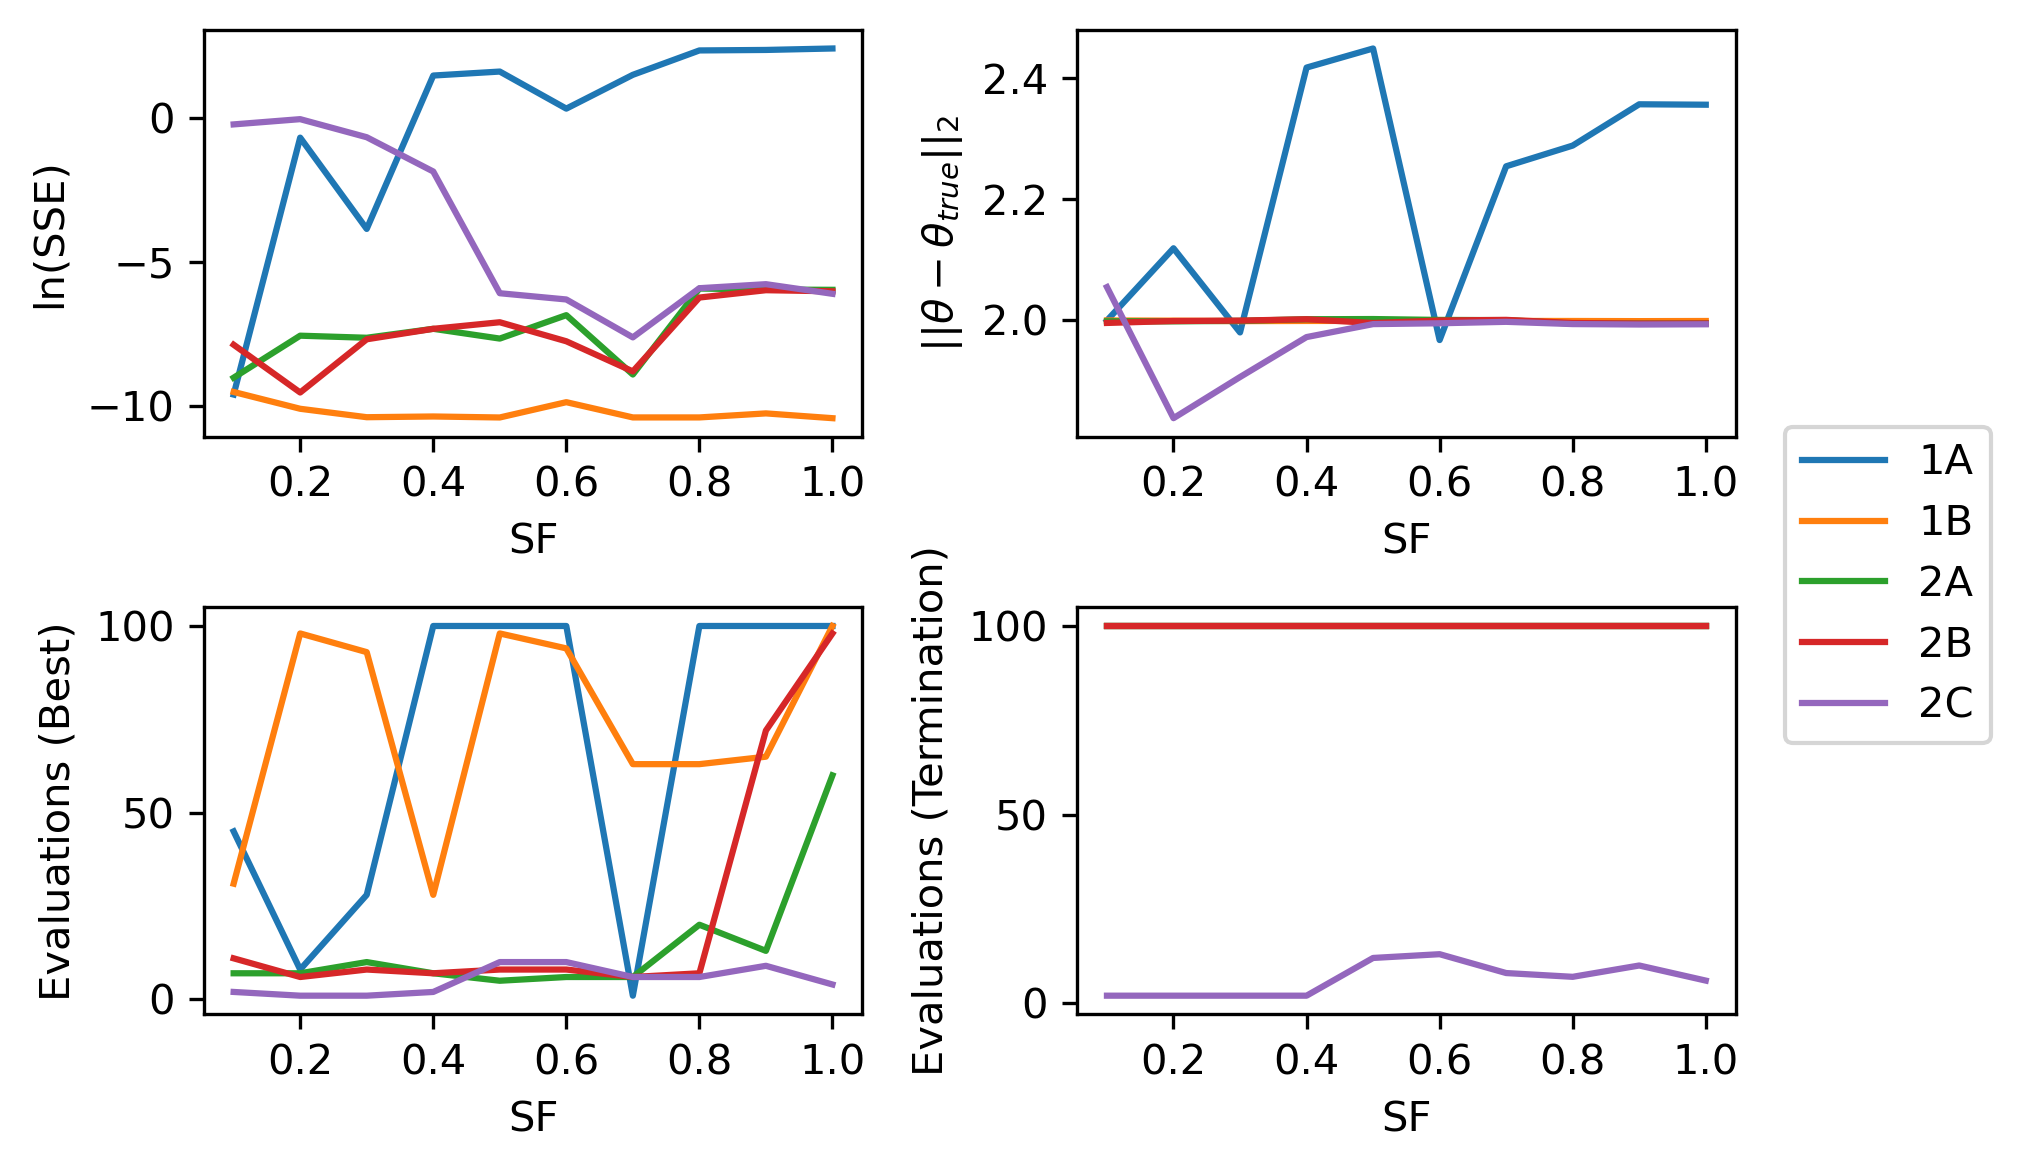

In [117]:
#Plot vs SF - log(SSE), L2 norm (Theta), iters for best sse, and termination

names=df['Method'].unique().tolist()


#Loop over mean, best, and median
for choice in ["mean", "median", "best"]:
    print(choice)
    #Make Figure and Subplots
    fig, ((ax_log_sse, ax_L2_theta), (ax_iter_best, ax_iter_term)) = plt.subplots(2, 2)
    #     plt.gca().axes.xaxis.set_ticklabels([]) # remove tick labels
    #     plt.gca().axes.yaxis.set_ticklabels([])

    #Set Axes Titles
    ax_log_sse.set(xlabel='SF', ylabel='ln(SSE)')
    ax_L2_theta.set(xlabel='SF', ylabel=r'$\vert\vert \theta - \theta_{true} \vert \vert_{2}$')
    ax_iter_best.set(xlabel='SF', ylabel='Evaluations (Best)')
    ax_iter_term.set(xlabel='SF', ylabel='Evaluations (Termination)')

    #Loop over number of methods
    for name in names:
        if choice == "best":
            df_plot = df_best.loc[(df_best['Method'] == name)] 
        elif choice == "median":
            df_plot = df_median.loc[(df_median['Method'] == name)]
        elif choice == "mean":
            df_plot = df_mean.loc[(df_mean['Method'] == name)]

        ax_log_sse.plot(df_plot['Separation Factor'], np.log(df_plot['Minimum SSE']), label = str(name))

        #Am I doing this right?
        df_theta_norm = np.linalg.norm(df_plot[['Theta 1','True Theta 1','Theta 2', 'True Theta 2']].values,axis=1)
        ax_L2_theta.plot(df_plot['Separation Factor'], df_theta_norm)

        ax_iter_best.plot(df_plot['Separation Factor'], df_plot["Iteration"])
        ax_iter_term.plot(df_plot['Separation Factor'], df_plot["Max Eval"])

    fig.legend(bbox_to_anchor=(1, 0.5), borderaxespad=0, loc = "center left")
    plt.tight_layout()
    #Set plot details
    # plt.xlabel("BO Iterations", fontsize=16,fontweight='bold')
    # plt.ylabel(r'$\mathbf{log(e(\theta))}$', fontsize=16,fontweight='bold')

    # plt.xticks(fontsize=16)
    # plt.yticks(fontsize=16)
    # plt.tick_params(direction="in",top=True, right=True)
    # plt.locator_params(axis='y', nbins=5)
    # plt.locator_params(axis='x', nbins=5)
    # plt.minorticks_on() # turn on minor ticks
    # plt.tick_params(which="minor",direction="in",top=True, right=True)
    plt.show()